In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import pandas as pd

In [9]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove final fc layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images).squeeze(-1).squeeze(-1)
        embeddings = self.fc(features)
        return embeddings  # [batch_size, embed_size]


class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder, embed_dim):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.fc = nn.Linear(embed_dim, decoder.config.n_embd)

    def forward(self, images, captions=None, attention_mask=None):
        img_embed = self.encoder(images)
        img_embed = self.fc(img_embed).unsqueeze(1)  # [B, 1, hidden_size]

        if captions is not None:
            inputs_embeds = self.decoder.transformer.wte(captions)
            inputs_embeds = torch.cat((img_embed, inputs_embeds), dim=1)

            if attention_mask is not None:
                prefix_mask = torch.ones(
                    (attention_mask.size(0), 1), dtype=attention_mask.dtype
                ).to(attention_mask.device)
                attention_mask = torch.cat((prefix_mask, attention_mask), dim=1)

            # Pad labels to match inputs_embeds length
            if captions.size(1) < inputs_embeds.size(1):
                pad_token_id = (
                    self.decoder.config.pad_token_id or tokenizer.eos_token_id
                )
                padding = torch.full(
                    (captions.size(0), 1),
                    pad_token_id,
                    dtype=captions.dtype,
                    device=captions.device,
                )
                captions = torch.cat((padding, captions), dim=1)

            outputs = self.decoder(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                labels=captions,
            )
            return outputs
        else:
            return img_embed


def tokenizer_and_decoder():
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    decoder = GPT2LMHeadModel.from_pretrained("gpt2")
    return tokenizer, decoder


class PromptDataset(Dataset):
    def __init__(self, csv_file, image_dir, tokenizer, transform=None, max_length=64):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row["file_name"])
        prompt = row["prompt"]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        encoding = self.tokenizer(
            prompt,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        return image, input_ids, attention_mask


def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    batch_losses = []


    for images, input_ids, attention_mask in dataloader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(images, captions=input_ids, attention_mask=attention_mask)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        batch_losses.append(loss.item())

    return total_loss / len(dataloader), batch_losses


if __name__ == "__main__":
    embed_dim = 512
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Updated paths for your full dataset
    csv_file = "./data/diffusiondb_sample.csv"
    image_dir = "./data/diffusiondb_images"

    tokenizer, decoder = tokenizer_and_decoder()
    encoder = EncoderCNN(embed_dim).to(device)
    model = ImageCaptioningModel(encoder, decoder, embed_dim).to(device)

    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    dataset = PromptDataset(csv_file, image_dir, tokenizer, transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

    num_epochs = 20
    all_epoch_losses = []
    all_batch_losses = []
    for epoch in range(num_epochs):
        epoch_loss, batch_losses = train(model, dataloader, optimizer, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
        all_epoch_losses.append(epoch_loss)
        all_batch_losses.extend(batch_losses)

    torch.save(model.state_dict(), "best_model.pth")
    print("Model saved as best_model.pth")

/opt/anaconda3/envs/image2prompt/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/image2prompt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/image2prompt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 1.9914
Epoch 2/20, Loss: 0.5125
Epoch 3/20, Loss: 0.2213
Epoch 4/20, Loss: 0.1489
Epoch 5/20, Loss: 0.1222
Epoch 6/20, Loss: 0.1022
Epoch 7/20, Loss: 0.0901
Epoch 8/20, Loss: 0.0797
Epoch 9/20, Loss: 0.0720
Epoch 10/20, Loss: 0.0673
Epoch 11/20, Loss: 0.0599
Epoch 12/20, Loss: 0.0574
Epoch 13/20, Loss: 0.0534
Epoch 14/20, Loss: 0.0468
Epoch 15/20, Loss: 0.0436
Epoch 16/20, Loss: 0.0469
Epoch 17/20, Loss: 0.0418
Epoch 18/20, Loss: 0.0471
Epoch 19/20, Loss: 0.0404
Epoch 20/20, Loss: 0.0367
Model saved as best_model.pth


In [5]:
import matplotlib.pyplot as plt

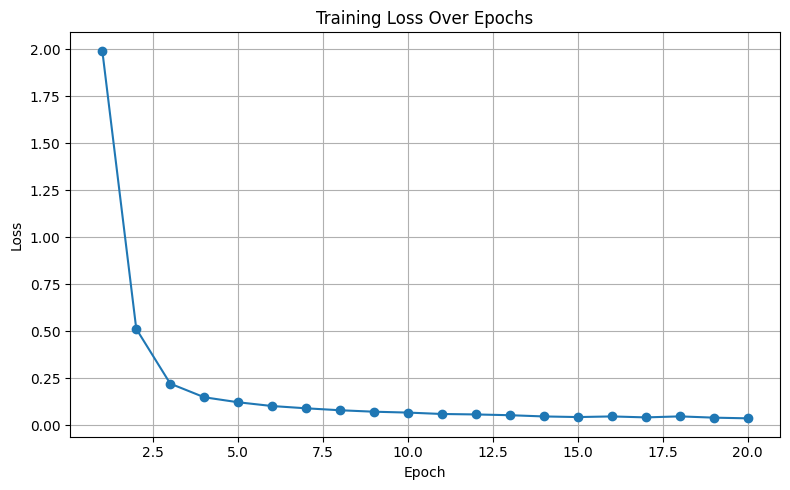

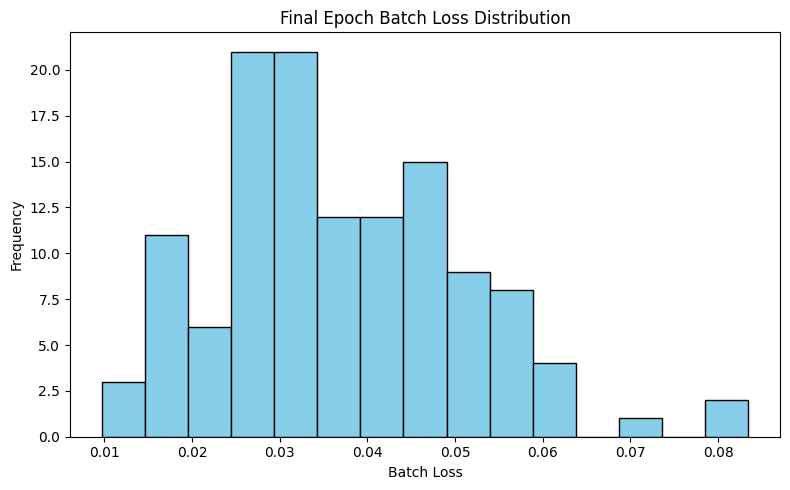

In [10]:
# Visualization directory
os.makedirs("visuals", exist_ok=True)

# Plot and save training loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_epoch_losses) + 1), all_epoch_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.savefig("visuals/loss_curve.png")

# Plot and save histogram of batch losses in the final epoch
plt.figure(figsize=(8, 5))
plt.hist(
    all_batch_losses[-len(dataloader) :],
    bins=15,
    color="skyblue",
    edgecolor="black",
)
plt.xlabel("Batch Loss")
plt.ylabel("Frequency")
plt.title("Final Epoch Batch Loss Distribution")
plt.tight_layout()
plt.savefig("visuals/final_epoch_loss_distribution.png")
